# Setup MongoDB Client

In [1]:
from modules.MongoDBScripts import *

# Extract from MongoDB to Local

In [2]:
merged_df = fetch_mongodb_to_dataframe(fused_features_set_collection)
merged_df

,median_TPM,protein_aa_freq_S,cdna_mfe,protein_instability,5utr_length,protein_aa_freq_C,protein_helix_frac,protein_aa_freq_K,protein_aa_freq_H,protein_aa_freq_P,...,esm_struct_374,esm_struct_375,esm_struct_376,esm_struct_377,esm_struct_378,esm_struct_379,esm_struct_380,esm_struct_381,esm_struct_382,esm_struct_383
0,-2.302585,0.069418,-14.397205,47.149737,6.066108,0.015009,0.292683,0.022514,0.018762,0.071295,...,73.373010,72.970220,12.923666,95.889725,51.059320,101.878426,-2.101057,-19.723396,135.783810,213.12137
1,2.432297,0.045082,-9.758310,36.974590,4.158883,0.012295,0.385246,0.049180,0.020492,0.061475,...,68.257310,60.291650,23.755404,109.030050,71.852974,96.979670,-5.143823,-20.785597,135.948970,225.27715
2,1.319086,0.088993,-11.061036,49.644988,5.093750,0.025761,0.271663,0.060890,0.035129,0.067916,...,83.333984,47.796707,10.249809,112.114845,54.815975,92.964690,13.249508,-8.416548,143.190410,230.09184
3,2.598607,0.078125,-10.534878,54.413438,5.393628,0.090625,0.321875,0.084375,0.037500,0.021875,...,59.012886,55.144268,7.491446,105.824670,103.813060,96.018524,-12.567250,-28.538748,109.231544,228.63722
4,2.086914,0.064516,-10.215169,34.719124,3.091042,0.011521,0.368664,0.087558,0.029954,0.018433,...,81.520420,42.850110,15.061850,79.176130,45.563927,76.292450,5.719397,-26.815514,141.263870,236.35191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7874,1.147402,0.082418,-10.814631,36.865934,4.882802,0.010989,0.346154,0.010989,0.010989,0.043956,...,68.545890,54.651220,27.990210,126.722830,88.860085,119.819840,-2.006317,-38.220192,116.409584,234.39198
7875,1.111858,0.074026,-12.283579,41.112610,5.273000,0.015584,0.385714,0.058442,0.025974,0.040260,...,62.303730,53.460125,37.014782,99.942940,69.377830,92.277370,6.069344,-22.673060,117.575730,221.72969
7876,1.214913,0.067265,-14.544234,53.725112,3.135494,0.015695,0.320628,0.024664,0.035874,0.065022,...,62.095028,67.709090,17.100504,102.763570,73.797020,109.286156,-3.990773,-7.868795,115.358430,216.32007
7877,1.249902,0.074380,-12.109897,64.338168,4.828314,0.016529,0.355372,0.045455,0.024793,0.068871,...,51.527200,73.513790,25.403866,105.522064,71.612724,99.531525,-12.912899,-21.747282,108.563416,217.93704


In [3]:
filtered_features = []
for column in merged_df.columns:
    if column.startswith("esm_") or column.startswith("emb"):
        continue

    filtered_features.append(column)

filtered_features

['median_TPM',
 'protein_aa_freq_S',
 'cdna_mfe',
 'protein_instability',
 '5utr_length',
 'protein_aa_freq_C',
 'protein_helix_frac',
 'protein_aa_freq_K',
 'protein_aa_freq_H',
 'protein_aa_freq_P',
 'protein_aa_freq_I',
 '3utr_paired_ratio',
 'protein_aa_freq_M',
 'kozak_score',
 'protein_aa_freq_A',
 'protein_abundance_log']

# Demonstration ProtAbRegressor with XGBoost

## Model Input Preparation (ML)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X = merged_df[filtered_features].drop("protein_abundance_log", axis=1)
y = merged_df["protein_abundance_log"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

## Load ProtAbRegressor XGBoost

In [5]:
import pickle
from sklearn.metrics import r2_score

with open('ProtAbRegressor_xgboost.pkl', 'rb') as file:
    model = pickle.load(file)

y_pred = model.predict(X_test_scaled)

r2_score(y_test, y_pred)

0.5011583856785717

# Demonstration ProtAbRegressor with Multimodal LSTM

## Model Input Preparation (DL)

In [8]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import random
import os


def set_seeds(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)


set_seeds(42)

gcnframe_embeddings = [col for col in merged_df.columns if col.startswith("emb_")]
helix_mrna_embeddings = [col for col in merged_df.columns if col.startswith("emb2_")]
esmfold_embeddings = [col for col in merged_df.columns if col.startswith("esm_")]
filtered_cols = [
    col
    for col in merged_df.columns
    if col not in gcnframe_embeddings
    and col not in helix_mrna_embeddings
    and col not in esmfold_embeddings
    and col != "protein_abundance_log"
]

X_embeddings1 = merged_df[gcnframe_embeddings].values  # Shape: (n_samples, 100)
X_embeddings2 = merged_df[helix_mrna_embeddings].values  # Shape: (n_samples, 256)
X_embeddings3 = merged_df[esmfold_embeddings].values  # Shape: (n_samples, 384)
X_filtered = merged_df[filtered_cols].values  # Shape: (n_samples, 15)
y = merged_df["protein_abundance_log"].values  # Shape: (n_samples,)

(
    X_emb1_train,
    X_emb1_test,
    X_emb2_train,
    X_emb2_test,
    X_emb3_train,
    X_emb3_test,
    X_filt_train,
    X_filt_test,
    y_train,
    y_test,
) = train_test_split(
    X_embeddings1,
    X_embeddings2,
    X_embeddings3,
    X_filtered,
    y,
    test_size=0.3,
    random_state=42,
)

# Scale all features including ESM embeddings
scaler_emb1 = StandardScaler()
X_emb1_train_scaled = scaler_emb1.fit_transform(X_emb1_train)
X_emb1_test_scaled = scaler_emb1.transform(X_emb1_test)

scaler_emb2 = StandardScaler()
X_emb2_train_scaled = scaler_emb2.fit_transform(X_emb2_train)
X_emb2_test_scaled = scaler_emb2.transform(X_emb2_test)

scaler_emb3 = StandardScaler()
X_emb3_train_scaled = scaler_emb3.fit_transform(X_emb3_train)
X_emb3_test_scaled = scaler_emb3.transform(X_emb3_test)

scaler_filt = StandardScaler()
X_filt_train_scaled = scaler_filt.fit_transform(X_filt_train)
X_filt_test_scaled = scaler_filt.transform(X_filt_test)

# Load ProtAbRegressor with Multimodal LSTM

In [9]:
model = load_model("ProtAbRegressor_multimodal_lstm.keras")

pred = model.predict(
    [X_emb1_test_scaled, X_emb2_test_scaled, X_emb3_test_scaled, X_filt_test_scaled]
).flatten()

print("Multimodal LSTM r2 score: ", r2_score(y_test, pred))

74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
Multimodal LSTM r2 score:  0.5026135488952627


# Visualization

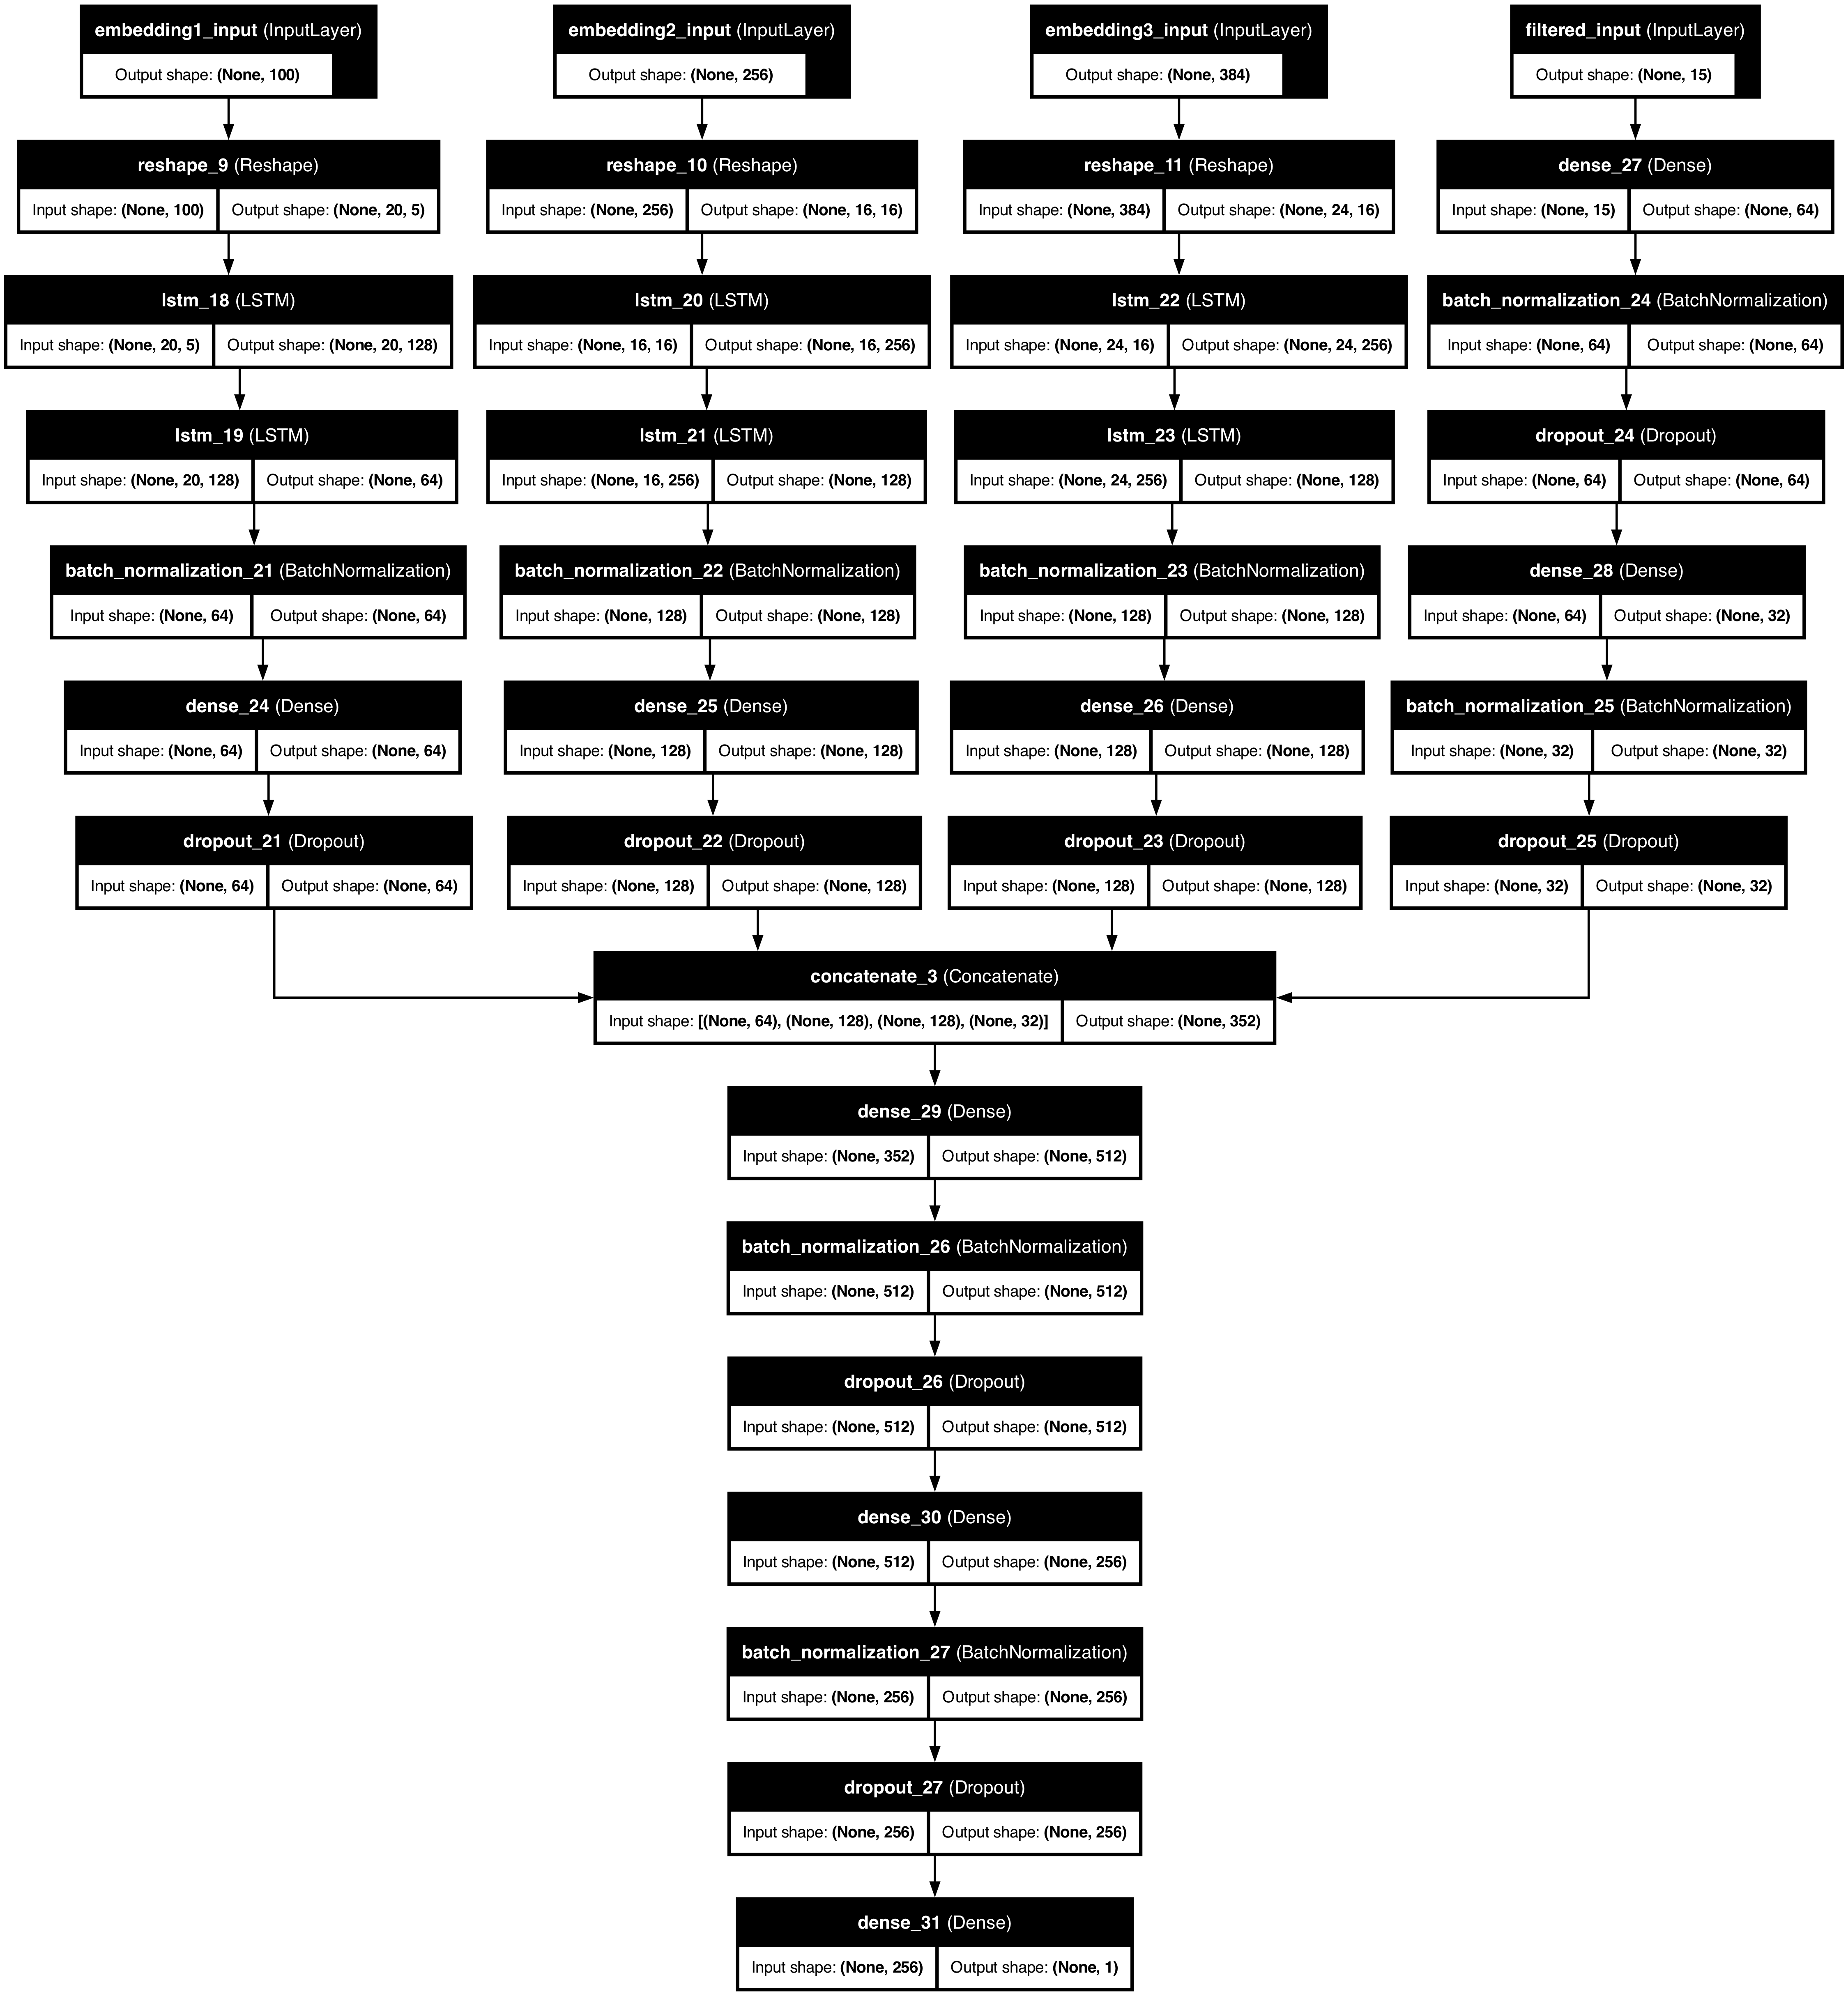

In [14]:
from tensorflow.keras.utils import plot_model
import os

os.environ["PATH"] += os.pathsep + "C:/Program Files/Graphviz/bin/"

# Generate the plot
plot_model(
    model,
    to_file="multimodal_lstm.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
)  # TB for top-to-bottom, LR for left-to-right